In [1]:
import functools

from agents.data_cleaning_agent import DataCleaningAgent
from agents.human_agent import HumanAgent
from agents.labeling_agent import LabelingAgent
from agents.tweet_collector_agent import TweetCollectorAgent
from langgraph.graph import StateGraph, START

from agents.supervisor_agent import SupervisorAgent
from langchain_core.messages import HumanMessage
from typing_extensions import TypedDict

In [2]:
class AgentState(TypedDict):
    messages: list[HumanMessage]
    next: str
    current_index: int
    data: dict
    context: str

In [3]:
members = ["Human", "TweetCollector", "DataCleaner", "Labeler"]

In [4]:
tweet_collector = TweetCollectorAgent()
data_cleaner = DataCleaningAgent()
labeler = LabelingAgent()
human_agent = HumanAgent()
supervisor = SupervisorAgent(members)

In [5]:
human_node = functools.partial(SupervisorAgent.agent_node, agent=human_agent, name="Human")
tweet_collector_node = functools.partial(SupervisorAgent.agent_node, agent=tweet_collector, name="TweetCollector")
data_cleaner_node = functools.partial(SupervisorAgent.agent_node, agent=data_cleaner, name="DataCleaner")
labeler_node = functools.partial(SupervisorAgent.agent_node, agent=labeler, name="Labeler")

In [6]:
workflow = StateGraph(AgentState)
workflow.add_node("Human", human_node)
workflow.add_node("TweetCollector", tweet_collector_node)
workflow.add_node("DataCleaner", data_cleaner_node)
workflow.add_node("Labeler", labeler_node)
workflow.add_node("supervisor", supervisor.supervisor_agent)

In [7]:
# Ajout des arêtes entre agents et le superviseur
for member in members:
    workflow.add_edge(member, "supervisor")

# Ajouter des arêtes conditionnelles à partir du superviseur
workflow.add_conditional_edges("supervisor", SupervisorAgent.supervisor_decision, supervisor.conditional_map())

# Ajouter le point d'entrée dans le workflow (HumanAgent)
workflow.add_edge(START, "Human")

# Compiler le workflow pour l'exécution
graph = workflow.compile()

In [8]:
# Définition de la structure de l'état initial du workflow
initial_context_message = HumanMessage(
    content="Provide context for the tweets you want to collect. "
            "For example: 'Collect tweets related to Kamala Harris.'"
)

# Définir l'état initial avec le message de contexte
initial_state = {
    "messages": [
        initial_context_message
    ],
    "data": {},
}

# Définir une limite de récursion pour éviter des boucles infinies dans le workflow
execution_config = {"recursion_limit": 150}

# Démarrer le flux d'exécution en utilisant la méthode `stream` du graphe
events = graph.stream(
    initial_state,
    execution_config,
)

# Parcourir les événements générés par le flux et les afficher
for event in events:
    print(event)
    print("----")


--------------------
{'messages': [HumanMessage(content='Context provided by human:', additional_kwargs={}, response_metadata={})], 'data': '', 'context': 'Kamala Harris'}
--------------------
{'Human': {'messages': [HumanMessage(content='Context provided by human:', additional_kwargs={}, response_metadata={}, name='Human')], 'data': '', 'context': 'Kamala Harris'}}
----
Le superviseur a choisi : TweetCollector
{'supervisor': {'messages': [HumanMessage(content='Context provided by human:', additional_kwargs={}, response_metadata={}, name='Human'), HumanMessage(content='Superviseur: Prochaine action - TweetCollector', additional_kwargs={}, response_metadata={})], 'next': 'TweetCollector', 'current_index': 1, 'data': '', 'context': 'Kamala Harris'}}
----
--------------------
{'messages': [HumanMessage(content='Context provided by human:', additional_kwargs={}, response_metadata={}, name='Human'), HumanMessage(content='Superviseur: Prochaine action - TweetCollector', additional_kwargs={},

/Users/MyMac/Documents/univReims/M2/systemeMultiAgents/sentimentAnalysis/agents/labeling_agent.py:23: LangChainDeprecationWarning: The method `BaseLLM.__call__` was deprecated in langchain-core 0.1.7 and will be removed in 1.0. Use :meth:`~invoke` instead.
  result = self.llm(prompt)


Query: Kamala Harris
Query: Kamala Harris
Query: Kamala Harris
Query: Kamala Harris
Query: Kamala Harris
Query: Kamala Harris
Query: Kamala Harris
Query: Kamala Harris
Query: Kamala Harris
Query: Kamala Harris
Query: Kamala Harris
Query: Kamala Harris
Query: Kamala Harris
Query: Kamala Harris
Query: Kamala Harris
Query: Kamala Harris
Query: Kamala Harris
Query: Kamala Harris
Query: Kamala Harris
Query: Kamala Harris
Query: Kamala Harris
Query: Kamala Harris
Query: Kamala Harris
Query: Kamala Harris
Query: Kamala Harris
Query: Kamala Harris
Query: Kamala Harris
Query: Kamala Harris
Query: Kamala Harris
Query: Kamala Harris
Query: Kamala Harris
Query: Kamala Harris
Query: Kamala Harris
Query: Kamala Harris
Query: Kamala Harris
Query: Kamala Harris
Query: Kamala Harris
Query: Kamala Harris
Query: Kamala Harris
Query: Kamala Harris
Query: Kamala Harris
Query: Kamala Harris
Query: Kamala Harris
Query: Kamala Harris
Query: Kamala Harris
Query: Kamala Harris
Query: Kamala Harris
Query: Kamala

In [10]:
import pandas as pd
df = pd.read_csv("tweets_labeled.csv")
df

,tweet,sentiment
0,breaking mark cuban just demolished donald tru...,NEGATIVE
1,afraid to debate donny darkness is golfing tod...,NEGATIVE
2,im leave this right here if donald trump was ...,NEGATIVE
3,breaking kamala harris just lost the 2024 ele...,NEGATIVE
4,prehostage tape mark cuban telling the truth a...,NEGATIVE
...,...,...
95,president zelenskyy held a meeting with a dem...,NEUTRAL
96,no amount of dead children is enough for joe b...,NEGATIVE
97,kid goes viral after delivering an answer th...,NEGATIVE
98,attention undecided voters here are kamala har...,POSITIVE


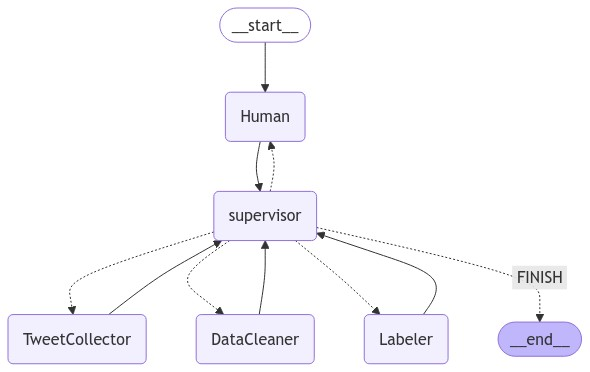

In [11]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    print("Erreur sur l'affichage")